In [ ]:
#!pip install helical==0.0.1a23
#!pip install gdown

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 26.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of gtfparse to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions 

In [1]:
from helical.utils import get_anndata_from_hf_dataset
from helical import GeneformerConfig, GeneformerFineTuningModel, scGPTConfig, scGPTFineTuningModel
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import logging, warnings
import umap
import pandas as pd
import seaborn as sns
import scanpy as sc
import os
import gdown
import anndata as ad
from datasets import load_dataset

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:datasets:PyTorch version 2.5.1 available.
INFO:datasets:Polars version 1.21.0 available.
INFO:datasets:TensorFlow version 2.18.0 available.
INFO:datasets:JAX version 0.5.2 available.
INFO:helical:Caduceus not available: If you want to use this model, ensure you have a CUDA GPU and have installed the optional helical[mamba-ssm] dependencies.


## Datos Helical

In [2]:
ds = load_dataset("helical-ai/yolksac_human",trust_remote_code=True, download_mode="reuse_cache_if_exists")

train_dataset = get_anndata_from_hf_dataset(ds["train"])
test_dataset = get_anndata_from_hf_dataset(ds["test"])

cell_types_train = list(np.array(train_dataset.obs["LVL3"].tolist())) # Cambiar niveles
cell_types_test = list(np.array(test_dataset.obs["LVL3"].tolist()))

label_set = set(cell_types_train) | set(cell_types_test)
class_id_dict = dict(zip(label_set, [i for i in range(len(label_set))]))
id_class_dict = {v: k for k, v in class_id_dict.items()}


for i in range(len(cell_types_train)):
    cell_types_train[i] = class_id_dict[cell_types_train[i]]

for i in range(len(cell_types_test)):
    cell_types_test[i] = class_id_dict[cell_types_test[i]]

sc.pp.highly_variable_genes(train_dataset, n_top_genes=3000, flavor='seurat_v3', inplace=True)
train_dataset = train_dataset[:, train_dataset.var["highly_variable"]]

sc.pp.highly_variable_genes(test_dataset, n_top_genes=3000, flavor='seurat_v3', inplace=True)
test_dataset = test_dataset[:, test_dataset.var["highly_variable"]]

y_true_test = test_dataset.obs["LVL3"].astype('category').cat.codes.to_numpy()

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

## Datos Esclerosis Múltiple

In [ ]:
output_dir = "../data/ms"
if os.path.exists(output_dir):

    print("data already downloaded!!")

else:

    folder_id = "1Qd42YNabzyr2pWt9xoY4cVMTAxsNBt4v"
    gdown.download_folder(f"https://drive.google.com/drive/folders/{folder_id}", output=output_dir, quiet=False)

Retrieving folder contents


Processing file 1Vp51xYAOEu5_Wd7lilnatvMJ7tr2bsbl .DS_Store
Processing file 1bV1SHKVZgkcL-RmmuN51_IIUJTSJbXOi c_data.h5ad
Processing file 1casFhq4InuBNhJLMnGebzkRXM2UTTeQG filtered_ms_adata.h5ad


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1Vp51xYAOEu5_Wd7lilnatvMJ7tr2bsbl
To: /data/ms/.DS_Store
100%|██████████| 6.15k/6.15k [00:00<00:00, 15.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1bV1SHKVZgkcL-RmmuN51_IIUJTSJbXOi
To: /data/ms/c_data.h5ad
100%|██████████| 20.6M/20.6M [00:00<00:00, 57.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1casFhq4InuBNhJLMnGebzkRXM2UTTeQG
To: /data/ms/filtered_ms_adata.h5ad
100%|██████████| 47.1M/47.1M [00:00<00:00, 65.5MB/s]
Download completed


In [ ]:
data_train = ad.read_h5ad(f'../data/ms/c_data.h5ad')
data_test = ad.read_h5ad(f'../data/ms/filtered_ms_adata.h5ad')

data_test.var = data_test.var.set_index('gene_name')
data_test.var["gene_name"] = data_test.var.index

cell_types_train = list(np.array(data_train.obs["celltype"].tolist()))
cell_types_test = list(np.array(data_test.obs["celltype"].tolist()))

label_set = set(cell_types_train) | set(cell_types_test) # Unimos ambos conjuntos
class_id_dict = dict(zip(label_set, [i for i in range(len(label_set))]))
id_class_dict = {v: k for k, v in class_id_dict.items()}


#Sustituimos los enteros por sus identificadores numéricos
for i in range(len(cell_types_train)):
    cell_types_train[i] = class_id_dict[cell_types_train[i]]

for i in range(len(cell_types_test)):
    cell_types_test[i] = class_id_dict[cell_types_test[i]]

# Modelo Geneformer

La idea es usar las dos versiones publicadas del modelo para así comprobar el efecto de escala en el rendimiento de las predicciones

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Versión pre-entrenada sobre 33-M células, 12 capas

In [4]:
geneformer_config = GeneformerConfig(device=device, batch_size=16, model_name="gf-12L-30M-i2048") # Primera versión
geneformer_fine_tune = GeneformerFineTuningModel(geneformer_config=geneformer_config, fine_tuning_head="classification", output_size=len(label_set))

INFO:helical.utils.downloader:Creating Folder /root/.cache/helical/models/geneformer/v1
INFO:helical.utils.downloader:File does not exist or has incorrect hash. Starting to download: 'https://helicalpackage.blob.core.windows.net/helicalpackage/data/geneformer/v1/gene_median_dictionary.pkl'
Downloading: 100%|██████████| 941k/941k [00:00<00:00, 1.42MB/s]
INFO:helical.utils.downloader:File saved to: '/root/.cache/helical/models/geneformer/v1/gene_median_dictionary.pkl'
INFO:helical.utils.downloader:File does not exist or has incorrect hash. Starting to download: 'https://helicalpackage.blob.core.windows.net/helicalpackage/data/geneformer/v1/token_dictionary.pkl'
Downloading: 100%|██████████| 788k/788k [00:00<00:00, 3.79MB/s]
INFO:helical.utils.downloader:File saved to: '/root/.cache/helical/models/geneformer/v1/token_dictionary.pkl'
INFO:helical.utils.downloader:File does not exist or has incorrect hash. Starting to download: 'https://helicalpackage.blob.core.windows.net/helicalpackage/da

## Aplicado a datos Helical

In [5]:
geneformerh_train_dataset = geneformer_fine_tune.process_data(train_dataset)
geneformerh_test_dataset = geneformer_fine_tune.process_data(test_dataset)

geneformerh_train_dataset = geneformerh_train_dataset.add_column("LVL3", cell_types_train) # Modificar niveles
geneformerh_test_dataset = geneformerh_test_dataset.add_column("LVL3", cell_types_test)

INFO:helical.models.geneformer.model:Processing data for Geneformer.
INFO:pyensembl.download_cache:Fetching /root/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.110.gtf.gz from URL https://ftp.ensembl.org/pub/release-110/gtf/homo_sapiens/Homo_sapiens.GRCh38.110.gtf.gz
INFO:datacache.download:Downloading https://ftp.ensembl.org/pub/release-110/gtf/homo_sapiens/Homo_sapiens.GRCh38.110.gtf.gz to /root/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.110.gtf.gz
INFO:pyensembl.download_cache:Fetching /root/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.cdna.all.fa.gz from URL https://ftp.ensembl.org/pub/release-110/fasta/homo_sapiens/cdna/Homo_sapiens.GRCh38.cdna.all.fa.gz
INFO:datacache.download:Downloading https://ftp.ensembl.org/pub/release-110/fasta/homo_sapiens/cdna/Homo_sapiens.GRCh38.cdna.all.fa.gz to /root/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.cdna.all.fa.gz
INFO:pyensembl.download_cache:Fetching /root/.cache/pyensembl/GRCh38/ensembl110/Homo_sa

Map:   0%|          | 0/25344 [00:00<?, ? examples/s]

INFO:helical.models.geneformer.model:Successfully processed the data for Geneformer.
INFO:helical.models.geneformer.model:Processing data for Geneformer.
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /root/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.cdna.all.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /root/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.ncrna.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /root/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.pep.all.fa.gz.pickle
INFO:helical.utils.mapping:Mapped 2789 genes to Ensembl IDs from a total of 3000 genes.
INFO:helical.models.geneformer.geneformer_tokenizer:AnnData object with n_obs × n_vars = 6336 × 3000
    obs: 'LVL1', 'LVL2', 'LVL3', 'total_counts'
    var: 'gene_name', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'index', 'ensembl_id'
    uns: 'hvg' has no column attribute 'filter_pass'; 

Map:   0%|          | 0/6336 [00:00<?, ? examples/s]

INFO:helical.models.geneformer.model:Successfully processed the data for Geneformer.


29:47 minutos

In [6]:
# Modificar etiquetas
geneformer_fine_tune.train(train_dataset=geneformerh_train_dataset.shuffle(), validation_dataset=geneformerh_test_dataset, label="LVL3", freeze_layers=0, epochs=1, optimizer_params={"lr": 1e-4}, lr_scheduler_params={"name":"linear", "num_warmup_steps":0, 'num_training_steps':1})

INFO:helical.models.geneformer.fine_tuning_model:Starting Fine-Tuning
Fine-Tuning Validation: 100%|██████████| 396/396 [02:42<00:00,  2.44it/s, val_loss=0.609]
INFO:helical.models.geneformer.fine_tuning_model:Fine-Tuning Complete. Epochs: 1


24 minutos

In [7]:
outputs_geneformerh_train = geneformer_fine_tune.get_outputs(geneformerh_train_dataset)
outputs_geneformerh_test = geneformer_fine_tune.get_outputs(geneformerh_test_dataset)

embeddings_geneformerh_train = geneformer_fine_tune.get_embeddings(geneformerh_train_dataset)
embeddings_geneformerh_test = geneformer_fine_tune.get_embeddings(geneformerh_test_dataset)

y_pred_test_h = outputs_geneformerh_test.argmax(axis=1)

Generating Outputs: 100%|██████████| 396/396 [02:40<00:00,  2.46it/s]
INFO:helical.models.geneformer.model:Started getting embeddings:


  0%|          | 0/1584 [00:00<?, ?it/s]

INFO:helical.models.geneformer.model:Finished getting embeddings.
INFO:helical.models.geneformer.model:Started getting embeddings:


  0%|          | 0/396 [00:00<?, ?it/s]

INFO:helical.models.geneformer.model:Finished getting embeddings.


### Resultados Helical

In [8]:
print("---- Resultados Train Datos Helical------")
print(classification_report(cell_types_train,outputs_geneformerh_train.argmax(axis=1)))

print("---- Resultados Test Datos Helical------")
print(classification_report(cell_types_test,outputs_geneformerh_test.argmax(axis=1)))

---- Resultados Train Datos Helical------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.98      0.96      0.97        47
           2       0.60      0.95      0.74      3466
           3       0.54      0.04      0.07       937
           4       0.70      0.92      0.79       125
           5       0.98      0.98      0.98      1152
           6       0.75      0.67      0.71       473
           7       0.64      0.73      0.68       159
           8       0.67      0.40      0.50        10
           9       0.25      0.37      0.30        46
          10       0.00      0.00      0.00        16
          11       0.00      0.00      0.00        11
          12       0.92      0.81      0.86       294
          13       0.00      0.00      0.00         1
          14       1.00      0.33      0.50         9
          15       0.00      0.00      0.00         2
          16       0.69      0.90      

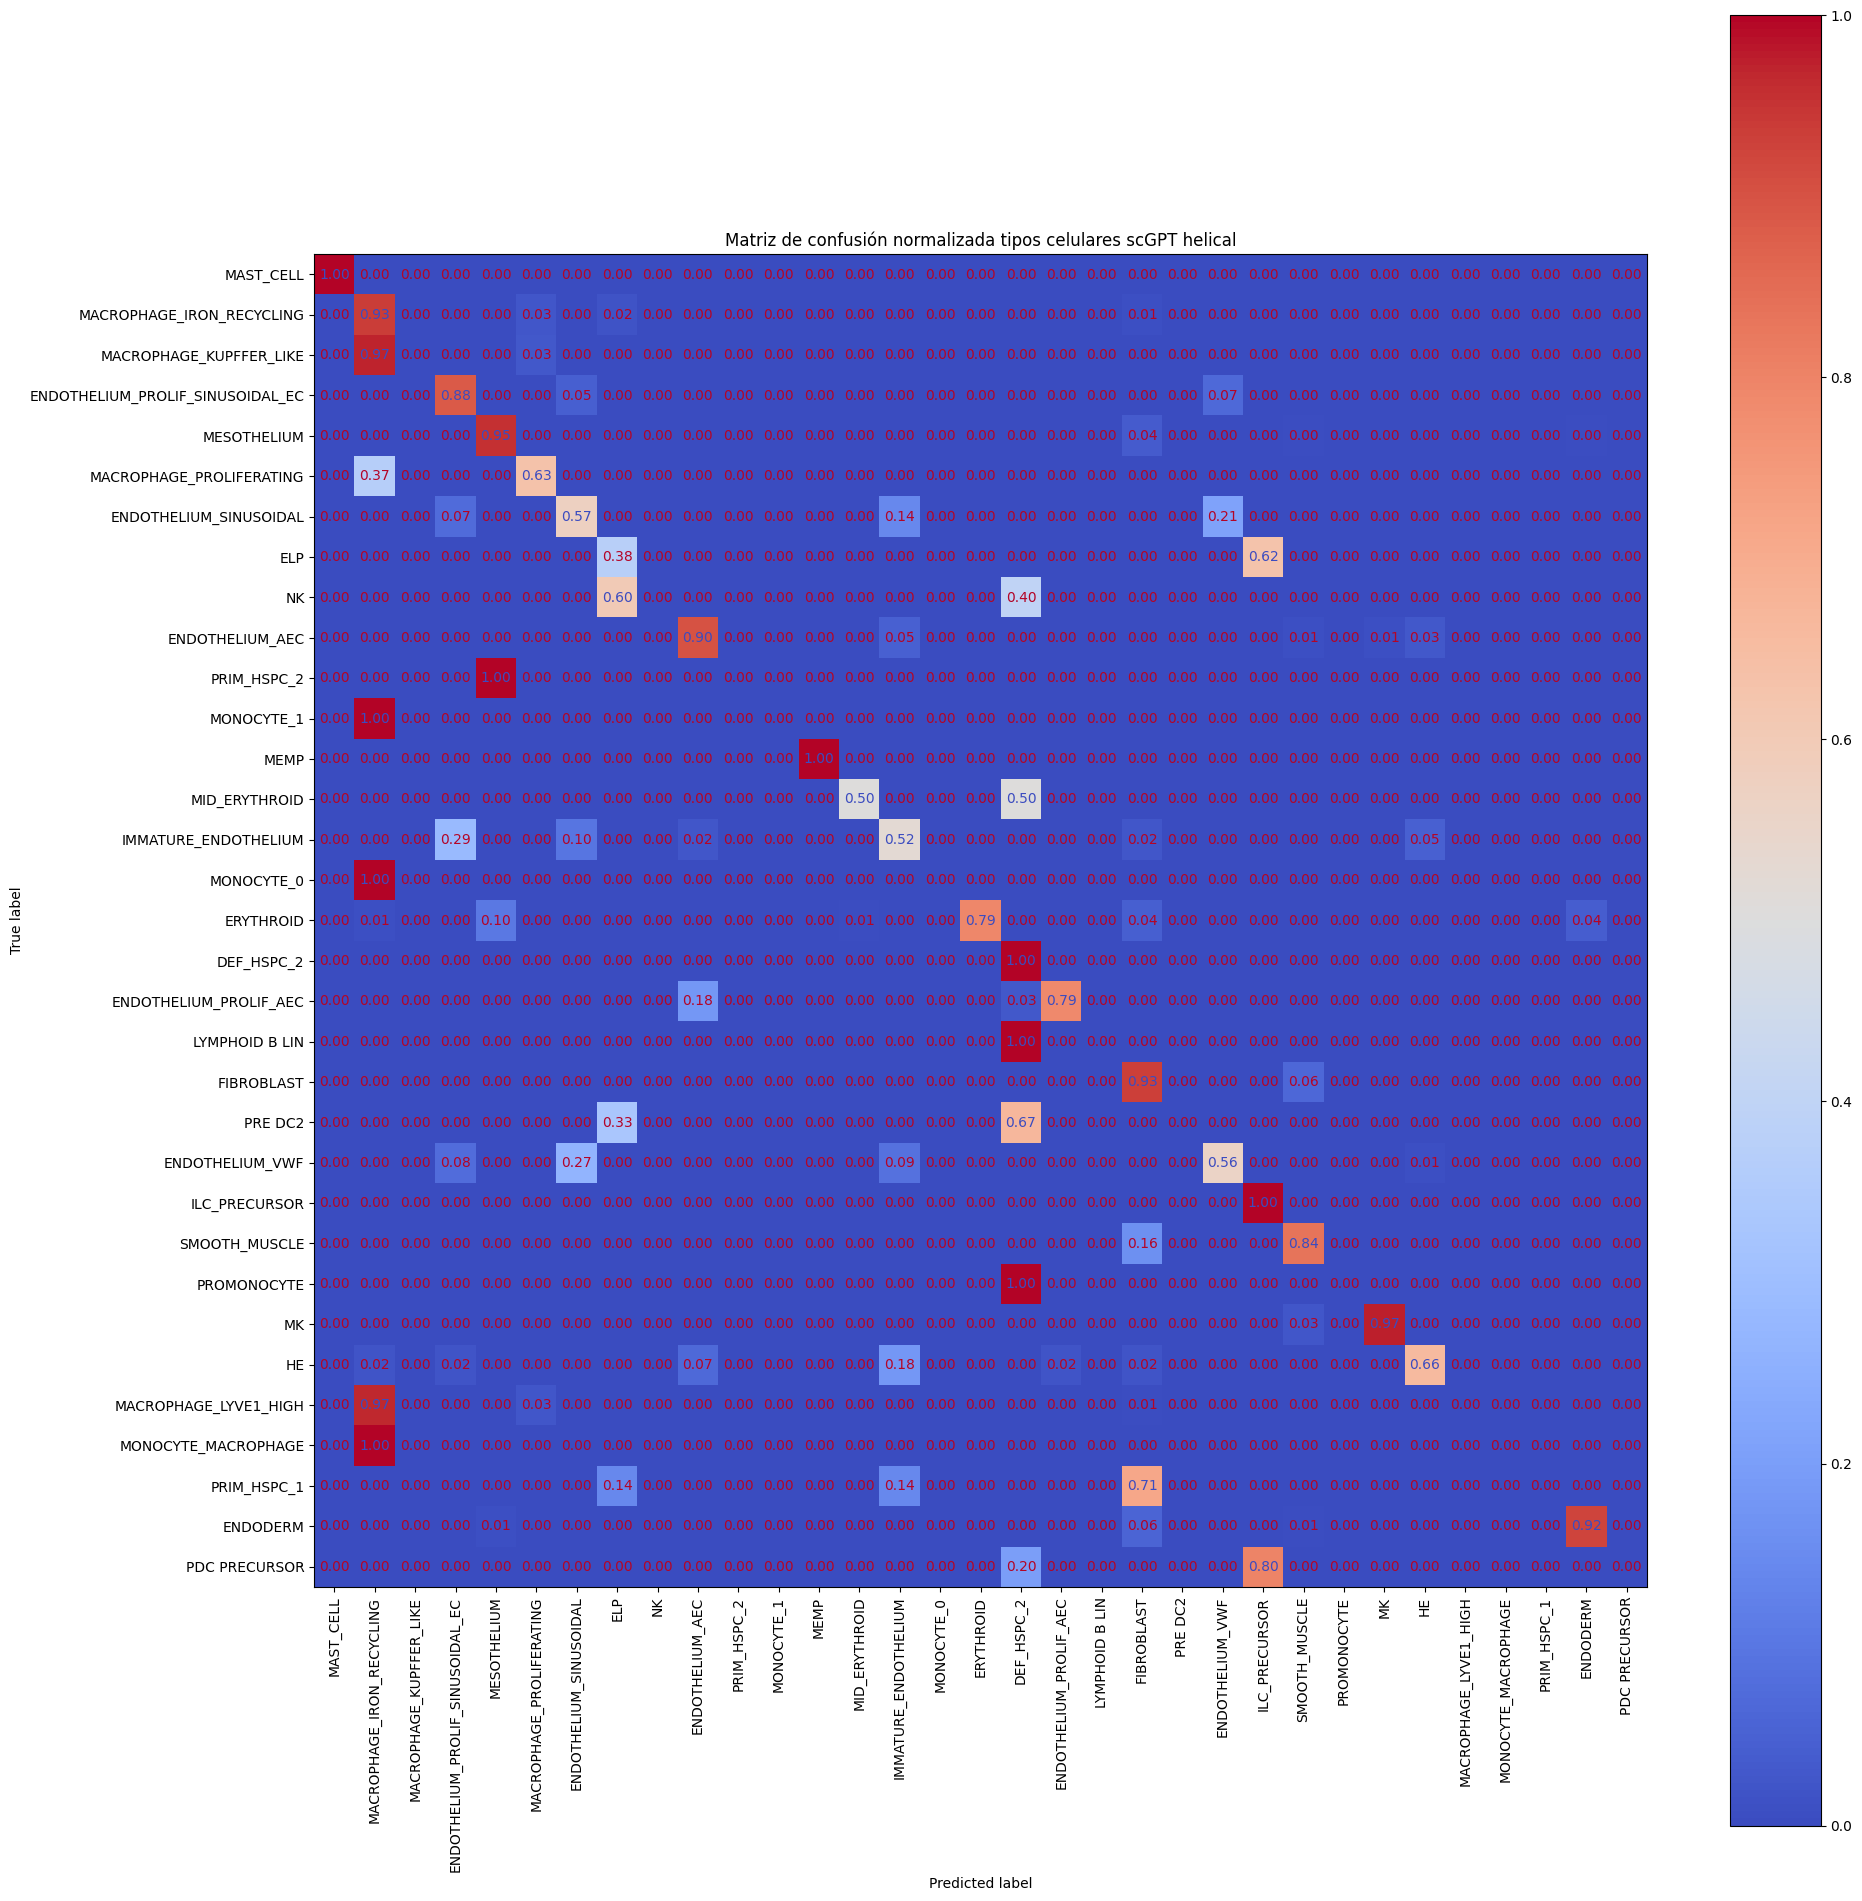

In [13]:
cm = confusion_matrix(cell_types_test, outputs_geneformerh_test.argmax(axis=1))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

unique_labels = np.unique(np.concatenate((cell_types_test, outputs_geneformerh_test.argmax(axis=1))))

class_names = [id_class_dict[label] for label in unique_labels]

fig, ax = plt.subplots(figsize=(20, 20))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
disp.plot(ax=ax, xticks_rotation='vertical', values_format='.2f', cmap='coolwarm')

ax.set_title('Matriz de confusión normalizada tipos celulares scGPT helical')
fig.set_facecolor("none")

plt.tight_layout()
plt.show()

## Aplicado a Esclerosis Múltiple

In [ ]:
geneformerm_train_dataset = geneformer_fine_tune.process_data(data_train, use_raw_counts=False)
geneformerm_test_dataset = geneformer_fine_tune.process_data(data_test, use_raw_counts=False)

geneformerm_train_dataset = geneformerm_train_dataset.add_column("TIPOS", cell_types_train)
geneformerm_test_dataset = geneformerm_test_dataset.add_column("TIPOS", cell_types_test)

INFO:helical.models.geneformer.model:Processing data for Geneformer.
INFO:pyensembl.download_cache:Fetching /root/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.110.gtf.gz from URL https://ftp.ensembl.org/pub/release-110/gtf/homo_sapiens/Homo_sapiens.GRCh38.110.gtf.gz
INFO:datacache.download:Downloading https://ftp.ensembl.org/pub/release-110/gtf/homo_sapiens/Homo_sapiens.GRCh38.110.gtf.gz to /root/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.110.gtf.gz
INFO:pyensembl.download_cache:Fetching /root/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.cdna.all.fa.gz from URL https://ftp.ensembl.org/pub/release-110/fasta/homo_sapiens/cdna/Homo_sapiens.GRCh38.cdna.all.fa.gz
INFO:datacache.download:Downloading https://ftp.ensembl.org/pub/release-110/fasta/homo_sapiens/cdna/Homo_sapiens.GRCh38.cdna.all.fa.gz to /root/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.cdna.all.fa.gz
INFO:pyensembl.download_cache:Fetching /root/.cache/pyensembl/GRCh38/ensembl110/Homo_sa

Map:   0%|          | 0/7844 [00:00<?, ? examples/s]

INFO:helical.models.geneformer.model:Successfully processed the data for Geneformer.
INFO:helical.models.geneformer.model:Processing data for Geneformer.
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /root/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.cdna.all.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /root/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.ncrna.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /root/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.pep.all.fa.gz.pickle
INFO:helical.utils.mapping:Mapped 2733 genes to Ensembl IDs from a total of 3000 genes.
INFO:helical.models.geneformer.geneformer_tokenizer:AnnData object with n_obs × n_vars = 13468 × 3000
    obs: 'Sample Characteristic[organism]', 'Sample Characteristic Ontology Term[organism]', 'Sample Characteristic[individual]', 'Sample Characteristic Ontology Term[individual]', 'Sample Characteristic[sex]', 'Sample Character

Map:   0%|          | 0/13468 [00:00<?, ? examples/s]

INFO:helical.models.geneformer.model:Successfully processed the data for Geneformer.


12 minutos

In [ ]:
geneformer_fine_tune.train(train_dataset=geneformerm_train_dataset.shuffle(), validation_dataset=geneformerm_test_dataset, label="TIPOS", freeze_layers=0, epochs=1, optimizer_params={"lr": 1e-4}, lr_scheduler_params={"name":"linear", "num_warmup_steps":0, 'num_training_steps':1})

INFO:helical.models.geneformer.fine_tuning_model:Starting Fine-Tuning
Fine-Tuning Validation: 100%|██████████| 842/842 [04:33<00:00,  3.08it/s, val_loss=0.68]
INFO:helical.models.geneformer.fine_tuning_model:Fine-Tuning Complete. Epochs: 1


13 minutos

In [ ]:
outputs_geneformerm_train = geneformer_fine_tune.get_outputs(geneformerm_train_dataset)
outputs_geneformerm_test = geneformer_fine_tune.get_outputs(geneformerm_test_dataset)

embeddings_geneformerm_train = geneformer_fine_tune.get_embeddings(geneformerm_train_dataset)
embeddings_geneformerm_test = geneformer_fine_tune.get_embeddings(geneformerm_test_dataset)

y_pred = outputs_geneformerm_test.argmax(axis=1)

Generating Outputs: 100%|██████████| 842/842 [04:30<00:00,  3.11it/s]
INFO:helical.models.geneformer.model:Started getting embeddings:


  0%|          | 0/491 [00:00<?, ?it/s]

INFO:helical.models.geneformer.model:Finished getting embeddings.
INFO:helical.models.geneformer.model:Started getting embeddings:


  0%|          | 0/842 [00:00<?, ?it/s]

INFO:helical.models.geneformer.model:Finished getting embeddings.


In [ ]:
print("---- Resultados Train Esclerosis------")
print(classification_report(cell_types_train,outputs_geneformerm_train.argmax(axis=1)))

print("---- Resultados Test Esclerosis------")
print(classification_report(cell_types_test,outputs_geneformerm_test.argmax(axis=1)))

---- Resultados Train Esclerosis------
              precision    recall  f1-score   support

           0       0.93      0.91      0.92        55
           1       0.67      0.02      0.03       114
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         3
           4       0.90      0.95      0.93       662
           5       0.65      0.88      0.75      1284
           6       0.89      0.94      0.92        53
           7       0.77      0.70      0.73       172
           8       0.94      0.99      0.97       154
           9       0.91      0.70      0.79       234
          10       0.92      0.91      0.91       413
          11       0.75      0.78      0.76       997
          12       0.77      0.73      0.75      1019
          13       0.90      0.76      0.82      2010
          14       0.83      0.93      0.87       569
          15       0.00      0.00      0.00         4
          16       0.93      0.97      0.9

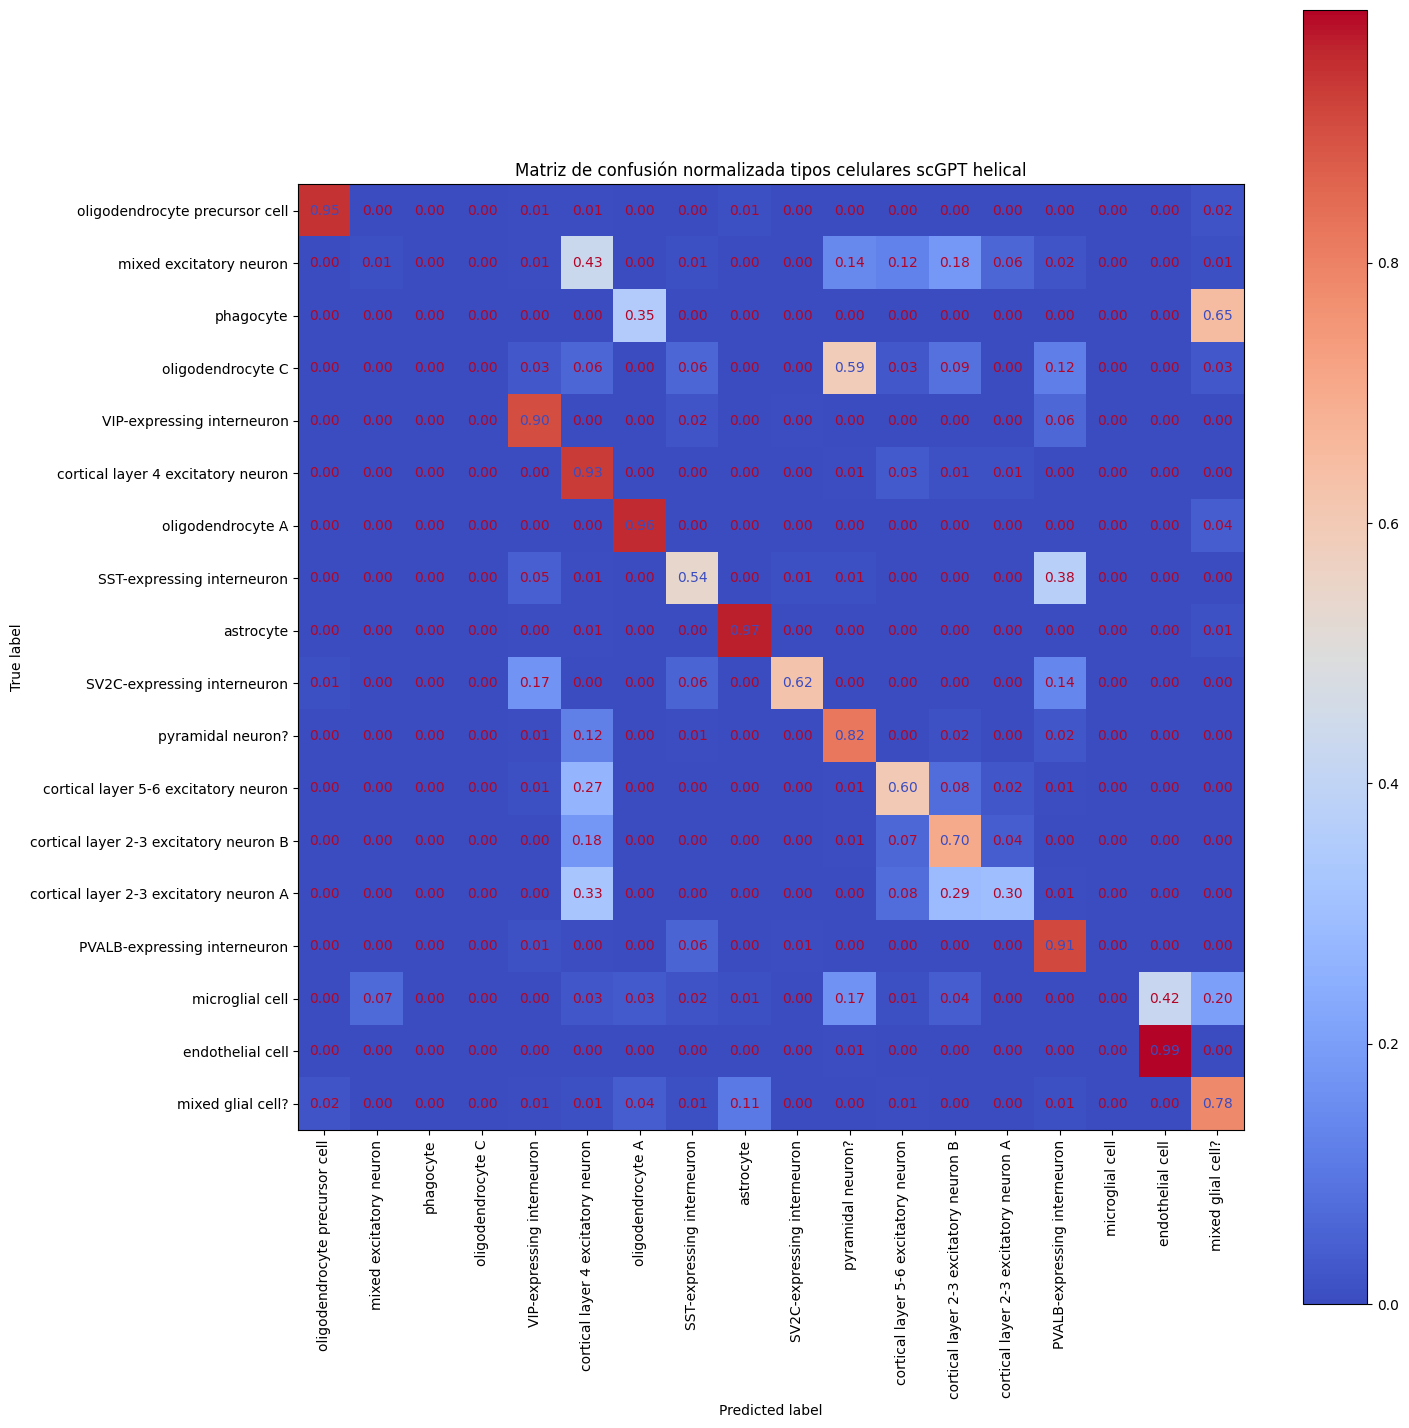

In [ ]:
cm = confusion_matrix(cell_types_test, outputs_geneformerm_test.argmax(axis=1))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

unique_labels = np.unique(np.concatenate((cell_types_test, outputs_geneformerm_test.argmax(axis=1))))

class_names = [id_class_dict[label] for label in unique_labels]

fig, ax = plt.subplots(figsize=(15, 15))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
disp.plot(ax=ax, xticks_rotation='vertical', values_format='.2f', cmap='coolwarm')

ax.set_title('Matriz de confusión normalizada tipos celulares scGPT ms')
fig.set_facecolor("none")

plt.tight_layout()
plt.show()

## Datos Esclerosis Múltiple

In [ ]:
embeddings_test = ad.AnnData(X=embeddings_geneformerm_test)
data_test.obsm["X_scgpt"] = embeddings_test.X

sc.tl.pca(embeddings_test)
data_test.obsm["X_pca"] = embeddings_test.obsm['X_pca']
data_test.uns["pca"] = embeddings_test.uns['pca']
data_test.varm['PCs'] = embeddings_test.varm['PCs']

sc.pp.neighbors(embeddings_test, use_rep="X")
sc.tl.umap(embeddings_test)

data_test.obsm["X_umap"] = embeddings_test.obsm["X_umap"]
data_test.uns["neighbors"] = embeddings_test.uns['neighbors']
data_test.obsp["distances"] = embeddings_test.obsp['distances']
data_test.obsp["connectivities"] = embeddings_test.obsp['connectivities']
data_test.obs["Preds"] = y_pred

sc.tl.tsne(data_test, use_rep = "X_pca", random_state = 0)

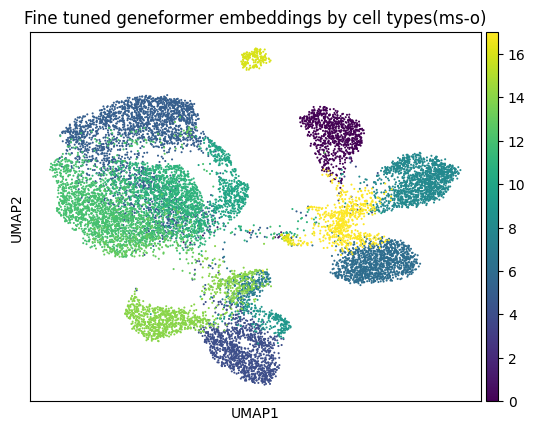

In [ ]:
sc.pl.umap(data_test, color=["Preds"], wspace = 0.6,title = "Fine tuned geneformer embeddings by cell type predictions(ms)")

In [ ]:
sc.pl.umap(data_test, color=["celltype"], wspace = 0.6,title = "Fine tuned geneformer embeddings by cell type(ms)")

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
sc.pl.tsne(data_test, color='celltype', ax=ax1, show=False, title='t-SNE scGPT fine-tuned embeddings ms', legend_fontsize=8)
sc.pl.umap(data_test, color='celltype', ax=ax2, show=False, title='UMAP scGPT fine-tuned embeddings ms', legend_fontsize=8)

plt.tight_layout()
plt.show()

## Datos Helical

In [10]:
embeddings_test = ad.AnnData(X=embeddings_geneformerh_test)
test_dataset.obsm["X_scgpt"] = embeddings_test.X


sc.tl.pca(embeddings_test)
test_dataset.obsm["X_pca"] = embeddings_test.obsm['X_pca']
test_dataset.uns["pca"] = embeddings_test.uns['pca']


sc.pp.neighbors(embeddings_test, use_rep="X")
sc.tl.umap(embeddings_test)

test_dataset.obsm["X_umap"] = embeddings_test.obsm["X_umap"]
test_dataset.uns["neighbors"] = embeddings_test.uns['neighbors']
test_dataset.obsp["distances"] = embeddings_test.obsp['distances']
test_dataset.obsp["connectivities"] = embeddings_test.obsp['connectivities']
test_dataset.obs["Preds"] = y_pred_test_h

sc.tl.tsne(test_dataset, use_rep = "X_pca", random_state = 0)

... storing 'LVL1' as categorical
... storing 'LVL2' as categorical
... storing 'LVL3' as categorical
... storing 'ensembl_id' as categorical


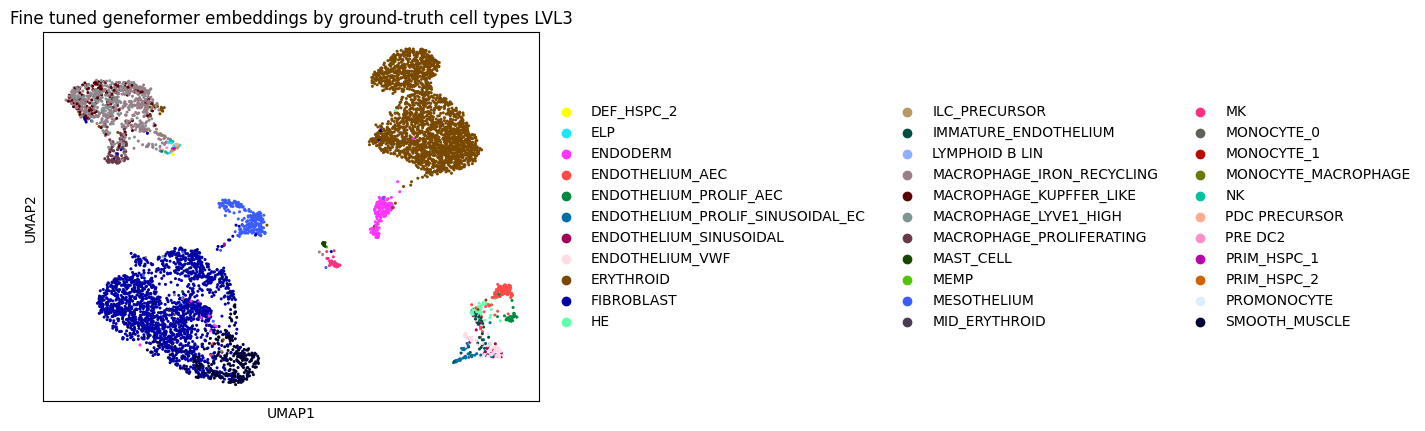

In [11]:
sc.pl.umap(test_dataset, color=["LVL3"], wspace = 0.6,title = "Fine tuned geneformer embeddings by ground-truth cell types LVL3")

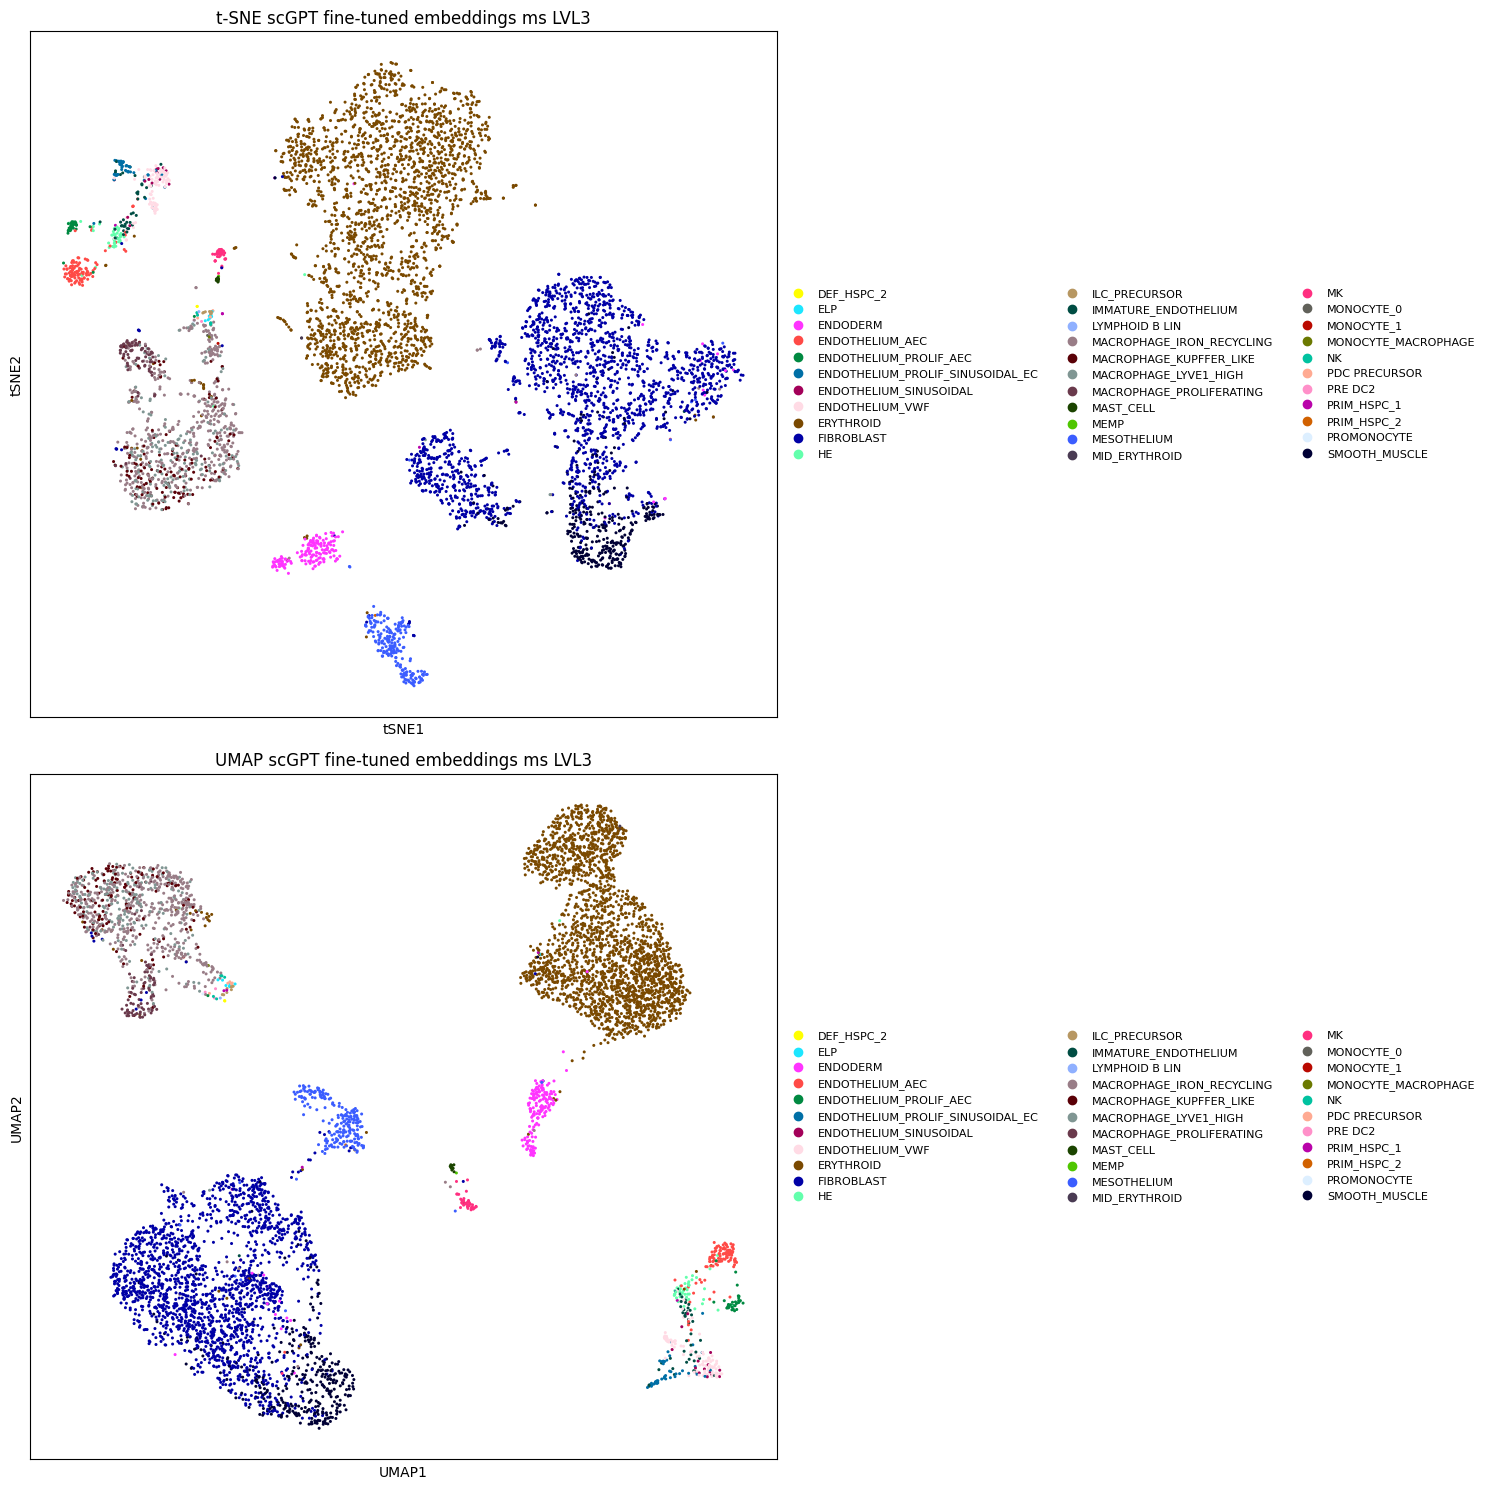

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 15))
# Cambiar niveles de clasificación
sc.pl.tsne(test_dataset, color='LVL3', ax=ax1, show=False, title='t-SNE scGPT fine-tuned embeddings ms LVL3', legend_fontsize=8)
sc.pl.umap(test_dataset, color='LVL3', ax=ax2, show=False, title='UMAP scGPT fine-tuned embeddings ms LVL3', legend_fontsize=8)

plt.tight_layout()
plt.show()